In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from qiskit import IBMQ, Aer, QuantumCircuit, transpile
from qiskit.circuit import Gate
import qiskit.compiler.transpiler as transpiler
from qiskit.transpiler.passes import DynamicalDecoupling
from qiskit.circuit.library import XGate
from qiskit.tools.monitor import job_monitor
from qiskit_experiments.database_service import DbExperimentDataV1 as DbExperimentData

sys.path.append('..')
from rttgen import LinearizedCR, PulseEfficientCR, CNOTBasedRtt
from cx_decomposition import cx_circuit
from calibrations import MeasurementErrorMitigation, MeasurementErrorExperiment, LinearizedCRRabiExperiment
from model_circuits import single_step_no_opt, single_step, two_steps
from trotter import trotter_step_circuits
from transpile_with_dd import transpile_with_dynamical_decoupling
from observables import combined_counts, plot_counts_with_curve

In [2]:
nsites = 2

aJ = 0.5 # Hamiltonian J parameter
am = 0.25 # Hamiltonian mu parameter

M = 17 # number of Trotter steps
omegadt = np.pi * 0.6 / M # Trotter step size

In [3]:
provider = IBMQ.load_account()
backend = provider.get_backend('ibm_lagos')
physical_qubits = [1, 2]

In [4]:
# # ibmq_jakarta [1, 3, 5, 6]
# lcr_experiment_ids = {
#     (1, 3): '3c6fff4e-70d5-4213-b35e-806889a6ba5d',
#     (3, 5): '8226300a-4505-4c43-ab45-46edfd5ff890',
#     (5, 6): 'c749fb50-6422-45f1-8635-ad36afc4a636'
# }
# mem_experiment_id = 'bcd21c47-462b-495a-b56e-52fd3b963dac'

# ibmq_quito [2, 1, 3, 4]
#lcr_experiment_ids = {
#    (2, 1): '8b75a6fa-acfd-4c5f-a007-e01e0e8935b0',
#    (1, 3): '526741cb-15b8-435a-b96f-52fd473e5cc5',
#    (3, 4): '86c7660c-f1aa-4e90-bf69-83f8c5bb3764'
#}
#mem_experiment_id = '5195e012-c16b-46c7-8213-1e74e5e3303a'

# ibmq_manila [1, 2, 3, 4]
# lcr_experiment_ids = {
#     (1, 2): '52729ad1-4b92-4cbc-8fad-8917da958786',
#     (2, 3): 'a2daa511-2edd-4f3e-8842-3f8f78daeb19',
#     (3, 4): '7dd46c29-23a6-4468-b1e4-6682285ef7a0'
# }
# mem_experiment_id = 'bded0990-72d4-403c-b3ec-360afac64fc9'

#ibm_kawasaki 
# lcr_experiment_ids = {
#     (1, 2): '',
#     (2, 3): '',
#     (3, 4): ''
# }
# mem_experiment_id = ''

#ibm_lagos
lcr_experiment_ids = {
    (1, 3): 'a89e1fc4-3099-4004-92a6-b899002c696c',
    (3, 5): '7d08fb09-2ec7-49da-8151-ffc08acdc8bd',
    (5, 4): '76424e56-0d18-457d-8bd2-e2ba2363c3c7'
}
mem_experiment_id = '13039ead-4dc1-4059-8ac6-cf63434464b9'

In [5]:
if not mem_experiment_id:
    exp = MeasurementErrorExperiment(physical_qubits, circuits_per_state=(backend.configuration().max_experiments // 32))
    exp_data = exp.run(backend=backend, shots=8192)
    print(exp_data.experiment_id)
    mem_experiment_id = exp_data.experiment_id
    exp_data.block_for_results()
    exp_data.save()

In [6]:
# for qubits in zip(physical_qubits[:-1], physical_qubits[1:]):
#     if not lcr_experiment_ids[tuple(qubits)]:
#         exp = LinearizedCRRabiExperiment(qubits, backend)
#         exp.circuits_per_point = backend.configuration().max_experiments // exp.width_values.shape[0] // 2
#         exp_data = exp.run(backend=backend, shots=8192)
#         print(exp_data.experiment_id)
#         lcr_experiment_ids[tuple(qubits)] = exp_data.experiment_id
#         exp_data.block_for_results()
#         exp_data.save()

In [7]:
mem = MeasurementErrorMitigation(backend, physical_qubits)

# for lcr in rtts_linear.values():
#     if lcr.native_direction:
#         qubits = (lcr.z_qubit, lcr.x_qubit)
#     else:
#         qubits = (lcr.x_qubit, lcr.z_qubit)

#     lcr.load_calibration(lcr_experiment_ids[qubits])

mem.load_matrix(mem_experiment_id)

## Test on simulator

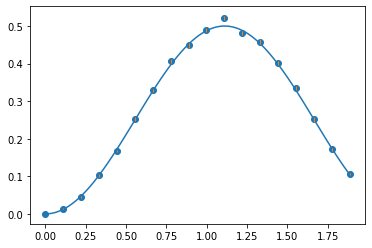

In [8]:
simulator = Aer.get_backend('qasm_simulator')
rtts_sim = {
    (0, 1): CNOTBasedRtt(simulator, (0, 1)),
    (1, 2): CNOTBasedRtt(simulator, (1, 2)),
    (2, 3): CNOTBasedRtt(simulator, (2, 3))
}
cxs_sim = {(0, 1): cx_circuit(simulator, 0, 1), (1, 0): cx_circuit(simulator, 1, 0)}

single_step_circuit = single_step(nsites, aJ, am, omegadt, rtts=rtts_sim, cxs=cxs_sim)
two_step_circuit = two_steps(nsites, aJ, am, omegadt, rtts=rtts_sim, cxs=cxs_sim)
circuits = trotter_step_circuits(M, (single_step_circuit, two_step_circuit))

job_cnot_sim = simulator.run(circuits, shots=8192)
plot_counts_with_curve(combined_counts(job_cnot_sim, M), nsites, aJ, am, omegadt, M)

## Define and submit all circuits

In [9]:
# rtts_linear = {
#     (0, 1): LinearizedCR(backend, tuple(physical_qubits[:2])),
#     (1, 2): LinearizedCR(backend, tuple(physical_qubits[1:3])),
#     (2, 3): LinearizedCR(backend, tuple(physical_qubits[2:]))
# }
rtts_pe = dict(((j, j + 1), PulseEfficientCR(backend, (physical_qubits[j], physical_qubits[j + 1]))) for j in range(nsites - 1))
rtts_cnot = dict(((j, j + 1), CNOTBasedRtt(backend, (physical_qubits[j], physical_qubits[j + 1]))) for j in range(nsites - 1))

cxs = {
    (0, 1): cx_circuit(backend, *tuple(physical_qubits[:2])),
    (1, 0): cx_circuit(backend, *tuple(physical_qubits[1::-1]))
}

In [10]:
# single_step_circuit = single_step(nsites, aJ, am, omegadt, rtts=rtts_linear, cxs=cxs)
# two_step_circuit = two_steps(nsites, aJ, am, omegadt, rtts=rtts_linear, cxs=cxs)
# circuits_linear = trotter_step_circuits(M, single_step_circuit, two_step_circuit)
# circuits_linear = transpile_dd(circuits_linear)

# job_linear = backend.run(circuits_linear, shots=8192)
# print('linear', job_linear.job_id())

# job_linear = backend.retrieve_job('616f8757cea633cf53145082')

In [11]:
pe_job_id = '61ad65301e11d53f566bd1a2'

if not pe_job_id:
    single_step_circuit = single_step(nsites, aJ, am, omegadt, rtts=rtts_pe, cxs=cxs)
    two_step_circuit = two_steps(nsites, aJ, am, omegadt, rtts=rtts_pe, cxs=cxs)
    circuits_pe = trotter_step_circuits(M, (single_step_circuit, two_step_circuit))
    circuits_pe = transpile_with_dynamical_decoupling(circuits_pe, backend=backend, initial_layout=physical_qubits, optimization_level=1)

    job_pe = backend.run(circuits_pe, shots=32000)
    print('pe', job_pe.job_id())
    pe_job_id = job_pe.job_id()
    
else:
    job_pe = backend.retrieve_job(pe_job_id)

In [12]:
# single_step_circuit = single_step_no_opt(nsites, aJ, am, omegadt)
# circuits_naive = trotter_step_circuits(M, single_step_circuit)
# circuits_naive = transpile_with_dynamical_decoupling(circuits_naive, backend=backend, physical_qubits=physical_qubits, optimization_level=3) * 4

# job_naive = backend.run(circuits_naive, shots=8192)
# print('naive', job_naive.job_id())

# job_naive = backend.retrieve_job('61704a019c88ce59b9b0ea1b')

In [13]:
cnot_job_id = '61ad6b2efd929e1f82d1a326'

if not cnot_job_id:
    single_step_circuit = single_step(nsites, aJ, am, omegadt, rtts=rtts_cnot, cxs=cxs)
    two_step_circuit = two_steps(nsites, aJ, am, omegadt, rtts=rtts_cnot, cxs=cxs)
    circuits_cnot = trotter_step_circuits(M, (single_step_circuit, two_step_circuit))
    circuits_cnot = transpile_with_dynamical_decoupling(circuits_cnot, backend=backend, initial_layout=physical_qubits, optimization_level=1)

    job_cnot = backend.run(circuits_cnot, shots=32000)
    print('cnot', job_cnot.job_id())
    cnot_job_id = job_cnot.job_id()
    
else:
    job_cnot = backend.retrieve_job(cnot_job_id)

## Forward steps with LinearizedCR

In [14]:
# plot_counts_with_curve(combined_counts(job_linear, M, mem_filter=mem), nsites, aJ, am, omegadt, M)

## Forward steps with Pulse-Efficient CR

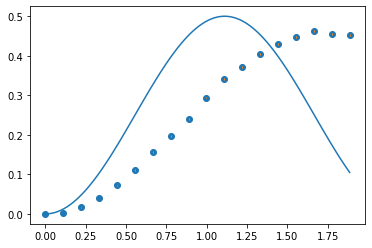

In [15]:
plot_counts_with_curve(combined_counts(job_pe, M, mem_filter=mem), nsites, aJ, am, omegadt, M)

## Forward with naive implementation (optimization level 3)

In [16]:
# plot_counts_with_curve(combined_counts(job_naive, M, mem_filter=mem), nsites, aJ, am, omegadt, M)

## Forward steps with CNOT-based Rtt

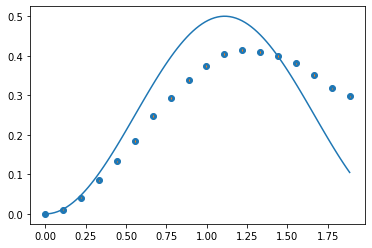

In [17]:
plot_counts_with_curve(combined_counts(job_cnot, M, mem_filter=mem), nsites, aJ, am, omegadt, M)